In [1]:
!pip install prophet --upgrade --quiet  
!pip install ipywidgets --upgrade --quiet
!pip install matplotlib --upgrade --quiet
!pip install numpy --upgrade --quiet
!pip install scikit-learn --upgrade --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.0 which is incompatible.


In [2]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


Importing plotly failed. Interactive plots will not work.


In [3]:
allData = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
allData.ds = pd.to_datetime(allData.ds)

In [4]:
allData.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,AMBVERT1,AMBVERTTBS,QTrack_TBS,Garage_TBS,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM
34561,2024-12-13 07:00:00,6,14,0,11,6,25,2,6,0,...,8,7,0.0,0.0,13,0,1,0,10,8
34562,2024-12-13 08:00:00,2,16,5,16,7,32,1,7,0,...,12,11,0.0,0.0,14,0,1,0,11,8
34563,2024-12-13 09:00:00,9,25,10,26,19,51,4,11,0,...,13,6,0.0,0.0,14,0,0,0,12,8
34564,2024-12-13 10:00:00,10,35,11,37,21,72,0,11,0,...,20,11,1.0,0.0,14,0,0,0,13,8
34565,2024-12-13 11:00:00,10,45,10,47,20,92,3,14,0,...,19,12,6.0,0.0,9,0,0,0,14,8


In [5]:
df = allData.copy()
df.isna().sum().sum()
df.ds = pd.to_datetime(df.ds)

In [6]:
# df.columns.to_list()
tbs_columns = [col for col in df.columns if 'TBS' in col]
tbs_columns

['TRG_HALLWAY_TBS',
 'POD_GREEN_TBS',
 'POD_YELLOW_TBS',
 'POD_ORANGE_TBS',
 'RAZ_TBS',
 'AMBVERTTBS',
 'QTrack_TBS',
 'Garage_TBS']

In [7]:
df['total_tbs'] = df[['TRG_HALLWAY_TBS',
 'POD_GREEN_TBS',
 'POD_YELLOW_TBS',
 'POD_ORANGE_TBS',
 'RAZ_TBS',
 'AMBVERTTBS',
 'QTrack_TBS',
 'Garage_TBS']].sum(axis=1)
df['vert_tbs'] = df[[
 'RAZ_TBS',
 'AMBVERTTBS',
 'QTrack_TBS',
 'Garage_TBS']].sum(axis=1)
df['pod_tbs'] = df[['TRG_HALLWAY_TBS',
 'POD_GREEN_TBS',
 'POD_YELLOW_TBS',
 'POD_ORANGE_TBS',
]].sum(axis=1)
df.tail()


,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,Garage_TBS,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs
34561,2024-12-13 07:00:00,6,14,0,11,6,25,2,6,0,...,0.0,13,0,1,0,10,8,10.0,7.0,3
34562,2024-12-13 08:00:00,2,16,5,16,7,32,1,7,0,...,0.0,14,0,1,0,11,8,15.0,11.0,4
34563,2024-12-13 09:00:00,9,25,10,26,19,51,4,11,0,...,0.0,14,0,0,0,12,8,14.0,10.0,4
34564,2024-12-13 10:00:00,10,35,11,37,21,72,0,11,0,...,0.0,14,0,0,0,13,8,19.0,16.0,3
34565,2024-12-13 11:00:00,10,45,10,47,20,92,3,14,0,...,0.0,9,0,0,0,14,8,23.0,18.0,5


In [8]:
# tbs_columns = ['total_tbs', 'vert_tbs', 'pod_tbs']
tbs_columns = ['total_tbs']

In [9]:
output = pd.DataFrame()
FIRST_RUN = True

for column in tqdm(tbs_columns):
    if column in ['ds']:
        continue
    try:
        print('working on '+column)

        m = Prophet(interval_width=0.95)
        m.fit(df[['ds', column]].rename(columns={column: 'y'}))
        future = m.make_future_dataframe(periods=24*1, freq='h')
        forecast = m.predict(future.tail(24*14))
        if FIRST_RUN:
            output['ds'] = forecast['ds']

        for forecast_column in ['yhat', 'yhat_lower', 'yhat_upper']:
            kwargs = {column+'_'+forecast_column: forecast[forecast_column]}
            output = output.assign(**kwargs)
        FIRST_RUN = False
    except:
        print(column + ' failed')

  0%|          | 0/1 [00:00<?, ?it/s]

working on total_tbs


12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:12<00:00, 12.37s/it]


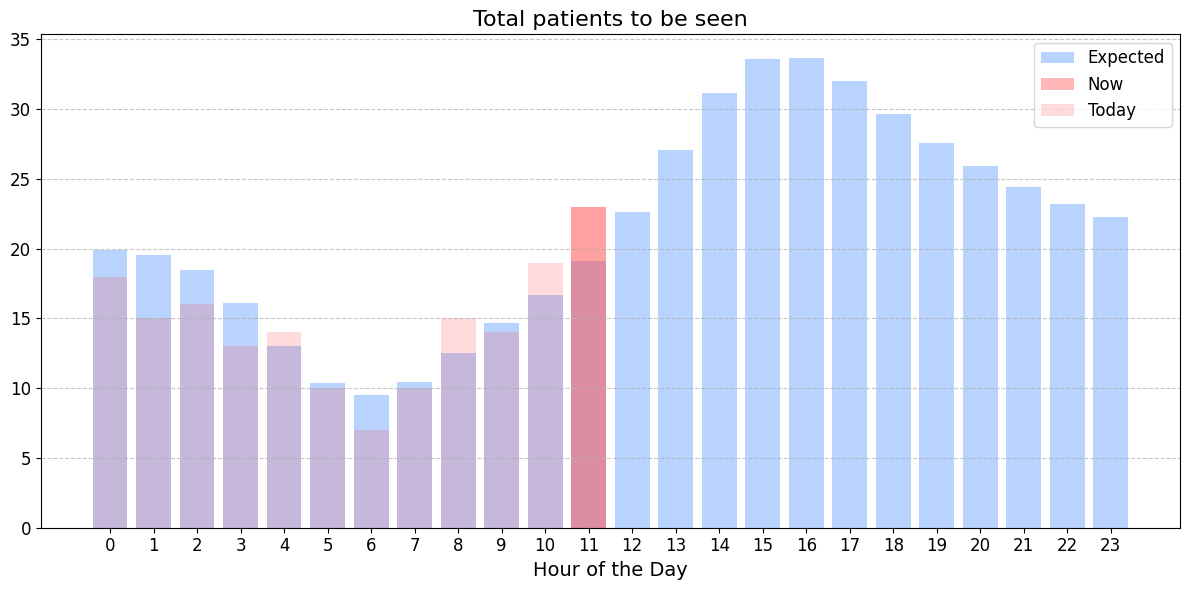

In [10]:
data = df.copy()

metric = 'total_tbs'

def create_metric_graph(metric):
    # Calculate total patients to be seen as the sum of specified columns

    # Extract hour from the timestamp for grouping
    data['Hour'] = pd.to_datetime(data['ds']).dt.hour

    # Group by hour and calculate the average number of patients for each hour
    hourly_data = data.groupby('Hour')[metric].mean()

    # Identify the most recent timestamp's hour and its corresponding value
    most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
    most_recent_hour = most_recent_timestamp.hour
    most_recent_value = data.loc[pd.to_datetime(data['ds']) == most_recent_timestamp, metric].iloc[0]
    recent_data = data.loc[pd.to_datetime(data['ds']) >= pd.to_datetime(most_recent_timestamp.date()), metric]
    recent_data = recent_data.reset_index(drop=True)

    # Extract the day of the week for the most recent timestamp
    most_recent_day_of_week = most_recent_timestamp.dayofweek

    # Filter the data to include only rows matching the same day of the week
    same_day_data = data[pd.to_datetime(data['ds']).dt.dayofweek == most_recent_day_of_week]

    # Group by hour and calculate the average number of patients for this specific day of the week
    hourly_data_same_day = same_day_data.groupby('Hour')[metric].mean()

    prophet_data = output[['ds', metric+'_yhat', metric+'_yhat_lower', metric+'_yhat_upper']].copy()
    prophet_data['Hour'] = pd.to_datetime(prophet_data['ds']).dt.hour
    prophet_data_today = prophet_data[prophet_data.ds.dt.date == most_recent_timestamp.date()]
    prophet_data_today = prophet_data_today.reset_index(drop=True)

    if most_recent_value > prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']:
        now_color = '#ff4d4d'
    else:
        now_color = '#ff4d4d'

    prophet_data_today.tail()
    # Plot the updated graph with colors matching the example and no vertical grid lines
    plt.figure(figsize=(12, 6))
    # plt.bar(hourly_data_same_day.index, hourly_data_same_day, color='#5293ff', alpha=0.4, label='Expected')
    plt.bar(prophet_data_today.index, prophet_data_today[metric+'_yhat'], color='#5293ff', alpha=0.4, label='Expected')

    plt.bar(
        most_recent_hour, most_recent_value, color=now_color, alpha=0.4, label='Now'
    )
    plt.bar(
        recent_data.index, recent_data, color='#ff4d4d', alpha=0.2, label='Today'
    )
    plt.xlabel('Hour of the Day', fontsize=14)
    # plt.ylabel(metric, fontsize=14)
    if metric == 'total_tbs':
        plt.title('Total patients to be seen', fontsize=16)
    elif metric == 'vert_tbs':
        plt.title('Vertical patients to be seen', fontsize=16)
    elif metric == 'pod_tbs':
        plt.title('Pod patients to be seen', fontsize=16)
    else:
        plt.title(metric, fontsize=16)
    plt.xticks(range(0, 24), fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(False, axis='x')  # Remove vertical grid lines
    plt.tight_layout()
    # plt.show()
    plt.savefig('../figures/'+metric+'.png')

for metric in tbs_columns:
    create_metric_graph(metric)

In [11]:
import base64
import io

# Get the latest figure
plt.gcf()

# Save figure to bytes buffer
buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Encode to base64
img_str = base64.b64encode(buffer.getvalue()).decode()
print(img_str)


iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8ekN5oAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAIyUlEQVR4nO3WMQEAIAzAMMC/5+ECjiYKenbPzCwAADLO7wAAAN4ygAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAAQIwBBACIMYAAADEGEAAgxgACAMQYQACAGAMIABBjAAEAYgwgAECMAQQAiDGAAAAxBhAAIMYAAgDEGEAAgBgDCAAQYwABAGIMIABAjAEEAIgxgAAAMQYQACDGAAIAxBhAAIAYAwgAEGMAAQBiDCAA

<Figure size 640x480 with 0 Axes>

In [24]:
column = 'total_tbs'
preds = m.predict(df[['ds', column]].rename(columns={column: 'y'}))

# Merge the actual data with prophet predictions on the datetime
merged_df = pd.merge(
    df[['ds', 'total_tbs']], 
    preds[['ds', 'yhat_upper']], 
    on='ds', 
    how='inner'
)

# Filter for times when actual values exceeded the upper prediction bound
exceeded_predictions = merged_df[merged_df['total_tbs'] > merged_df['yhat_upper']]

# Sort by datetime and display
exceeded_predictions = exceeded_predictions.sort_values('ds', ascending=False)
print(f"Found {len(exceeded_predictions)} instances where actual values exceeded predictions")
exceeded_predictions.head()

Found 1153 instances where actual values exceeded predictions


,ds,total_tbs,yhat_upper
34549,2024-12-12 19:00:00,43.0,41.766038
34548,2024-12-12 18:00:00,47.0,42.982209
34477,2024-12-09 19:00:00,46.0,45.125377
34476,2024-12-09 18:00:00,58.0,46.944530
34475,2024-12-09 17:00:00,52.0,48.020390


In [30]:
len(exceeded_predictions[exceeded_predictions.ds>'2024-11-01'].ds.dt.date.unique())

17

In [25]:
len(exceeded_predictions.ds.dt.date.unique())/len(df)

0.009753415142394072

In [143]:
merged_df

,ds,total_tbs,total_tbs_yhat_upper
0,2024-11-28 22:00:00,16.0,41.294896
1,2024-11-28 23:00:00,20.0,41.209344
2,2024-11-29 00:00:00,18.0,40.227248
3,2024-11-29 01:00:00,20.0,40.637795
4,2024-11-29 02:00:00,23.0,38.712213
...,...,...,...
307,2024-12-11 17:00:00,37.0,48.835484
308,2024-12-11 18:00:00,45.0,46.503971
309,2024-12-11 19:00:00,38.0,44.516653
310,2024-12-11 20:00:00,36.0,43.512730


13.0

In [147]:
column = 'total_tbs'
m = Prophet(interval_width=0.95)
# Add all columns except 'ds' and target column as regressors
regressor_columns = [col for col in df.columns if col not in ['ds', column]]
for regressor in regressor_columns:
    m.add_regressor(regressor)

# Fit the model with all features
m.fit(df.rename(columns={column: 'y'}))

21:37:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:31 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
future = m.make_future_dataframe(periods=24*1, freq='h')
# Need to add all regressor columns to future dataframe before predicting
for regressor in regressor_columns:
    future[regressor] = 0  # Initialize with 0 or appropriate default values

forecast = m.predict(future.tail(24*14))
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,AMBVERT1,AMBVERT1_lower,AMBVERT1_upper,AMBVERTTBS,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
331,2024-12-12 17:00:00,21.115657,-0.052271,0.025147,21.115657,21.115657,0.00064,0.00064,0.00064,-6.407872,...,-0.000125,-0.000125,-0.000125,0.037570,0.037570,0.037570,0.0,0.0,0.0,-0.013927
332,2024-12-12 18:00:00,21.115642,-0.055925,0.026816,21.115642,21.115642,0.00064,0.00064,0.00064,-6.407872,...,-0.000125,-0.000125,-0.000125,0.037556,0.037556,0.037556,0.0,0.0,0.0,-0.013889
333,2024-12-12 19:00:00,21.115628,-0.052544,0.023575,21.115628,21.115628,0.00064,0.00064,0.00064,-6.407872,...,-0.000125,-0.000125,-0.000125,0.037542,0.037542,0.037542,0.0,0.0,0.0,-0.013870
334,2024-12-12 20:00:00,21.115613,-0.049996,0.026604,21.115613,21.115613,0.00064,0.00064,0.00064,-6.407872,...,-0.000124,-0.000124,-0.000124,0.037528,0.037528,0.037528,0.0,0.0,0.0,-0.013849
335,2024-12-12 21:00:00,21.115599,-0.052712,0.024596,21.115599,21.115599,0.00064,0.00064,0.00064,-6.407872,...,-0.000122,-0.000122,-0.000122,0.037514,0.037514,0.037514,0.0,0.0,0.0,-0.013797


In [157]:
from prophet.diagnostics import cross_validation, performance_metrics

column = 'total_tbs'
m = Prophet(interval_width=0.95)

# Add the Hour column to df before fitting
df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek  # Also add DayOfWeek if you want to use it

# Add seasonality parameters
m.add_seasonality(name='hourly', period=24, fourier_order=8)
m.add_seasonality(name='weekly', period=7*24, fourier_order=3)

# Add country holidays
m.add_country_holidays(country_name='CA')

# Add regressors
m.add_regressor('Hour', mode='multiplicative')
m.add_regressor('DayOfWeek', mode='multiplicative')

# Increase the number of MCMC iterations and chains
# m.mcmc_samples = 1000
# m.stan_backend.chains = 4

# Fit the model
m.fit(df.rename(columns={column: 'y'}))
df_cv = cross_validation(m, initial='1070 days', period='15 days', horizon = '24 hours', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)

22:16:07 - cmdstanpy - INFO - Chain [1] done processing
22:16:13 - cmdstanpy - INFO - Chain [1] start processing
22:16:26 - cmdstanpy - INFO - Chain [1] start processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing
22:16:27 - cmdstanpy - INFO - Chain [1] done processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing
22:16:46 - cmdstanpy - INFO - Chain [1] done processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing
22:16:48 - cmdstanpy - INFO - Chain [1] done processing
22:16:51 - cmdstanpy - INFO - Chain [1] done processing
22:16:53 - cmdstanpy - INFO - Chain [1] start processing
22:16:53 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:24 - cmdstanpy - INFO - Chain [1] d

In [158]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,103.580607,10.177456,7.688207,0.439299,0.24176,0.316735,0.901667


In [165]:
import numpy as np
from sklearn.metrics import mean_squared_error


column = 'total_tbs'

# Python
from prophet.make_holidays import make_holidays_df

qc_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='CA', province='QC'
)
# qc_holidays.head(n=10)
for daily_seasonality in [0.1, 1, 10, 100]:
    m = Prophet(interval_width=0.95, holidays=qc_holidays, daily_seasonality=daily_seasonality)

    # Add the Hour column to df before fitting
    # df['Hour'] = df['ds'].dt.hour
    # df['DayOfWeek'] = df['ds'].dt.dayofweek  # Also add DayOfWeek if you want to use it

    # Add seasonality parameters
    # m.add_seasonality(name='hourly', period=24, fourier_order=8)
    # m.add_seasonality(name='weekly', period=7*24, fourier_order=3)

    # Add country holidays
    m.add_country_holidays(country_name='CA')

    # Add regressors
    # m.add_regressor('Hour', mode='multiplicative')
    # m.add_regressor('DayOfWeek', mode='multiplicative')

    # Increase the number of MCMC iterations and chains
    # m.mcmc_samples = 1000
    # m.stan_backend.chains = 4

    # Fit the model
    m.fit(df.rename(columns={column: 'y'}))

    # Get predictions for historical dates
    historical_forecast = m.predict(df)

    # Calculate RMSE between actual and predicted values
    rmse = np.sqrt(mean_squared_error(df[column], historical_forecast['yhat']))
    print(f"RMSE for {column}: {rmse:.2f}")


22:53:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:37 - cmdstanpy - INFO - Chain [1] done processing


RMSE for total_tbs: 10.81


22:54:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] done processing


RMSE for total_tbs: 8.57


22:56:03 - cmdstanpy - INFO - Chain [1] start processing
22:56:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE for total_tbs: 8.18


22:57:36 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [29]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.5, 1],
    'seasonality_prior_scale': [10, 50, 100],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df.rename(columns={column: 'y'}))  # Fit model with given params
    # df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    # df_p = performance_metrics(df_cv, rolling_window=1)
    historical_forecast = m.predict(df)

    # Calculate RMSE between actual and predicted values
    rmse = np.sqrt(mean_squared_error(df[column], historical_forecast['yhat']))
    # print(f"RMSE for {column}: {rmse:.2f}")
    rmses.append(rmse)
    print(param_grid, rmse)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

13:57:17 - cmdstanpy - INFO - Chain [1] start processing
13:57:26 - cmdstanpy - INFO - Chain [1] done processing
13:57:33 - cmdstanpy - INFO - Chain [1] start processing
13:57:43 - cmdstanpy - INFO - Chain [1] done processing
13:57:50 - cmdstanpy - INFO - Chain [1] start processing
13:58:01 - cmdstanpy - INFO - Chain [1] done processing
13:58:08 - cmdstanpy - INFO - Chain [1] start processing
13:58:16 - cmdstanpy - INFO - Chain [1] done processing
13:58:24 - cmdstanpy - INFO - Chain [1] start processing
13:58:36 - cmdstanpy - INFO - Chain [1] done processing
13:58:44 - cmdstanpy - INFO - Chain [1] start processing
13:58:51 - cmdstanpy - INFO - Chain [1] done processing


   changepoint_prior_scale  seasonality_prior_scale      rmse
0                      0.5                       10  2.525191
1                      0.5                       50  2.524459
2                      0.5                      100  2.524530
3                      1.0                       10  2.524726
4                      1.0                       50  2.524613
5                      1.0                      100  2.524635


  0%|          | 0/3 [00:00<?, ?it/s]

working on total_tbs


15:34:37 - cmdstanpy - INFO - Chain [1] start processing
15:34:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:17<00:35, 17.69s/it]

working on vert_tbs


15:34:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:39<00:20, 20.22s/it]

working on pod_tbs


15:35:17 - cmdstanpy - INFO - Chain [1] start processing
15:35:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:50<00:00, 16.87s/it]


uploaded as b'total_tbs.png'
uploaded as b'vert_tbs.png'
uploaded as b'pod_tbs.png'


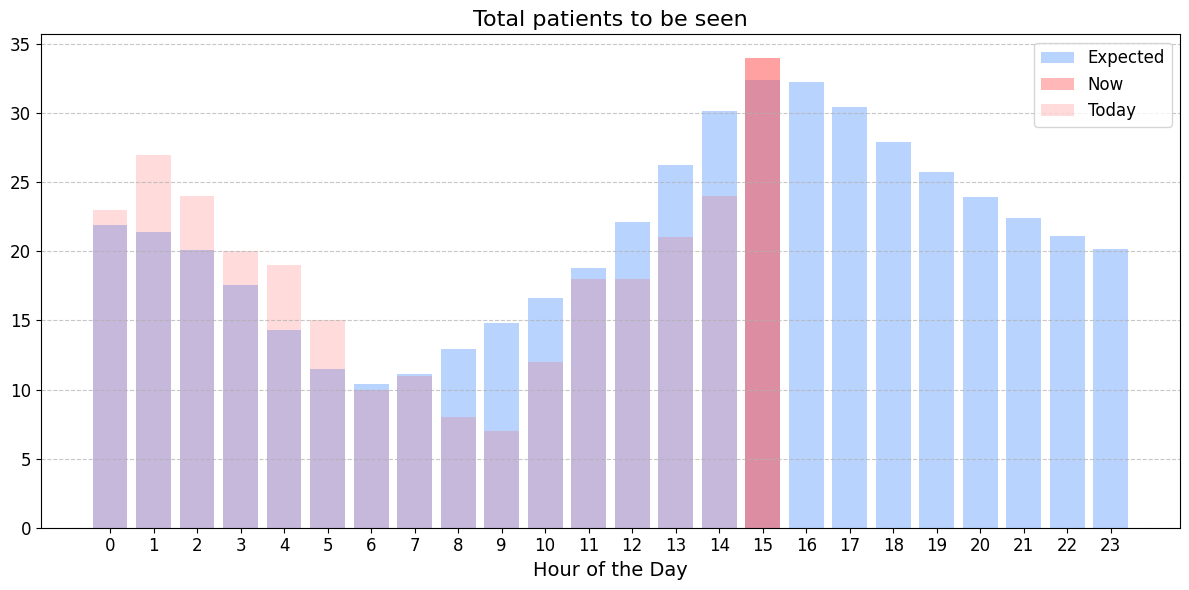

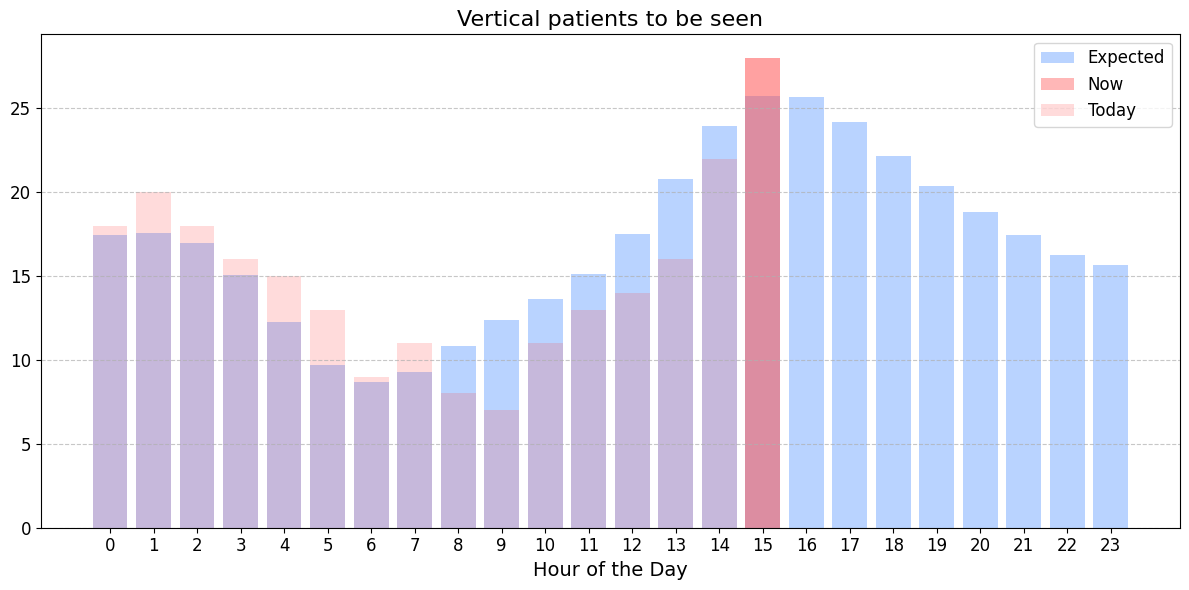

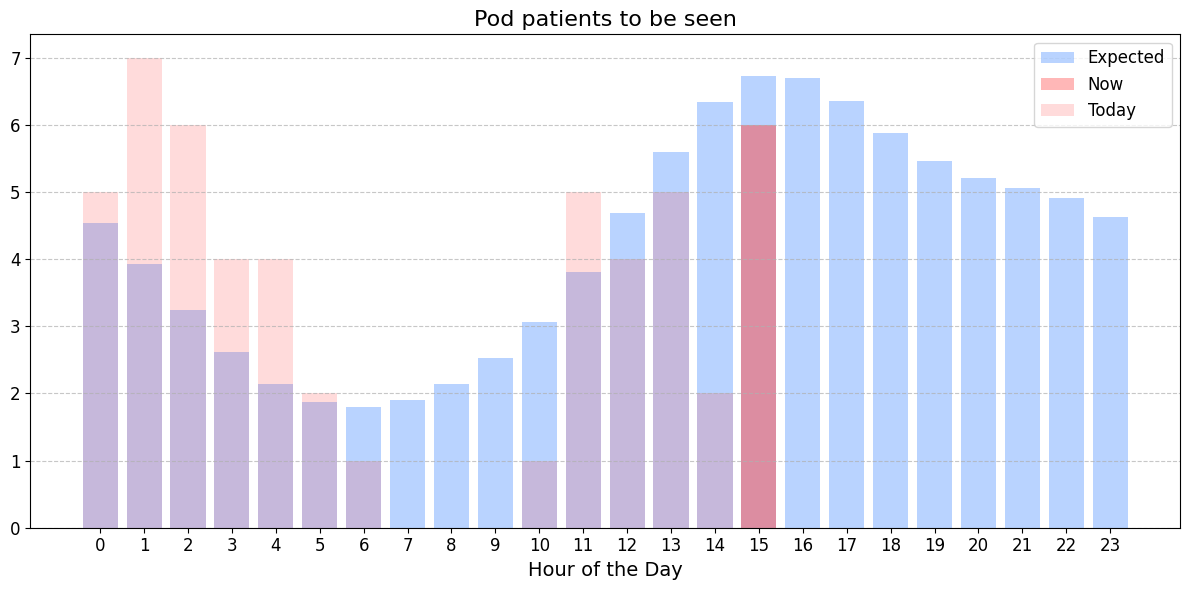

In [2]:
import os
import requests
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from utils import upload
import dropbox

load_dotenv()

allData = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
allData.ds = pd.to_datetime(allData.ds)

df = allData.copy()
df.ds = pd.to_datetime(df.ds)

df['total_tbs'] = df[['TRG_HALLWAY_TBS',
 'POD_GREEN_TBS',
 'POD_YELLOW_TBS',
 'POD_ORANGE_TBS',
 'RAZ_TBS',
 'AMBVERTTBS',
 'QTrack_TBS',
 'Garage_TBS']].sum(axis=1)
df['vert_tbs'] = df[[
 'RAZ_TBS',
 'AMBVERTTBS',
 'QTrack_TBS',
 'Garage_TBS']].sum(axis=1)
df['pod_tbs'] = df[['TRG_HALLWAY_TBS',
 'POD_GREEN_TBS',
 'POD_YELLOW_TBS',
 'POD_ORANGE_TBS',
]].sum(axis=1)
df.tail()

tbs_columns = ['total_tbs', 'vert_tbs', 'pod_tbs']

output = pd.DataFrame()
FIRST_RUN = True

for column in tqdm(tbs_columns):
    if column in ['ds']:
        continue
    try:
        print('working on '+column)

        m = Prophet(interval_width=0.95)
        m.fit(df[['ds', column]].rename(columns={column: 'y'}))
        future = m.make_future_dataframe(periods=24*1, freq='h')
        forecast = m.predict(future.tail(24*14))
        if FIRST_RUN:
            output['ds'] = forecast['ds']

        for forecast_column in ['yhat', 'yhat_lower', 'yhat_upper']:
            kwargs = {column+'_'+forecast_column: forecast[forecast_column]}
            output = output.assign(**kwargs)
        FIRST_RUN = False
    except:
        print(column + ' failed')

data = df.copy()

def create_metric_graph(metric):
    # Calculate total patients to be seen as the sum of specified columns

    # Extract hour from the timestamp for grouping
    data['Hour'] = pd.to_datetime(data['ds']).dt.hour

    # Group by hour and calculate the average number of patients for each hour
    hourly_data = data.groupby('Hour')[metric].mean()

    # Identify the most recent timestamp's hour and its corresponding value
    most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
    most_recent_hour = most_recent_timestamp.hour
    most_recent_value = data.loc[pd.to_datetime(data['ds']) == most_recent_timestamp, metric].iloc[0]
    recent_data = data.loc[pd.to_datetime(data['ds']) >= pd.to_datetime(most_recent_timestamp.date()), metric]
    recent_data = recent_data.reset_index(drop=True)

    # Extract the day of the week for the most recent timestamp
    most_recent_day_of_week = most_recent_timestamp.dayofweek

    # Filter the data to include only rows matching the same day of the week
    same_day_data = data[pd.to_datetime(data['ds']).dt.dayofweek == most_recent_day_of_week]

    # Group by hour and calculate the average number of patients for this specific day of the week
    hourly_data_same_day = same_day_data.groupby('Hour')[metric].mean()

    prophet_data = output[['ds', metric+'_yhat', metric+'_yhat_lower', metric+'_yhat_upper']].copy()
    prophet_data['Hour'] = pd.to_datetime(prophet_data['ds']).dt.hour
    prophet_data_today = prophet_data[prophet_data.ds.dt.date == most_recent_timestamp.date()]
    prophet_data_today = prophet_data_today.reset_index(drop=True)

    if most_recent_value > prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']:
        now_color = '#ff4d4d'
    else:
        now_color = '#ff4d4d'

    prophet_data_today.tail()
    # Plot the updated graph with colors matching the example and no vertical grid lines
    plt.figure(figsize=(12, 6))
    # plt.bar(hourly_data_same_day.index, hourly_data_same_day, color='#5293ff', alpha=0.4, label='Expected')
    plt.bar(prophet_data_today.index, prophet_data_today[metric+'_yhat'], color='#5293ff', alpha=0.4, label='Expected')

    plt.bar(
        most_recent_hour, most_recent_value, color=now_color, alpha=0.4, label='Now'
    )
    plt.bar(
        recent_data.index, recent_data, color='#ff4d4d', alpha=0.2, label='Today'
    )
    plt.xlabel('Hour of the Day', fontsize=14)
    # plt.ylabel(metric, fontsize=14)
    if metric == 'total_tbs':
        plt.title('Total patients to be seen', fontsize=16)
    elif metric == 'vert_tbs':
        plt.title('Vertical patients to be seen', fontsize=16)
    elif metric == 'pod_tbs':
        plt.title('Pod patients to be seen', fontsize=16)
    else:
        plt.title(metric, fontsize=16)
    plt.xticks(range(0, 24), fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(False, axis='x')  # Remove vertical grid lines
    plt.tight_layout()
    # plt.show()
    plt.savefig(metric+'.png')

for metric in tbs_columns:
    create_metric_graph(metric)


dropbox_app_key = os.environ.get("DROPBOX_APP_KEY")
dropbox_app_secret = os.environ.get("DROPBOX_APP_SECRET")
dropbox_refresh_token = os.environ.get("DROPBOX_REFRESH_TOKEN")

# exchange the authorization code for an access token:
token_url = "https://api.dropboxapi.com/oauth2/token"
params = {
    "grant_type": "refresh_token",
    "refresh_token": dropbox_refresh_token,
    "client_id": dropbox_app_key,
    "client_secret": dropbox_app_secret
}
r = requests.post(token_url, data=params)
# print(r.text)

dropbox_access_token = r.json()['access_token']

dbx = dropbox.Dropbox(dropbox_access_token)

for metric in tbs_columns:
    upload(dbx, metric+'.png', '', '',
            metric+'.png', overwrite=True)


total_tbs not critical


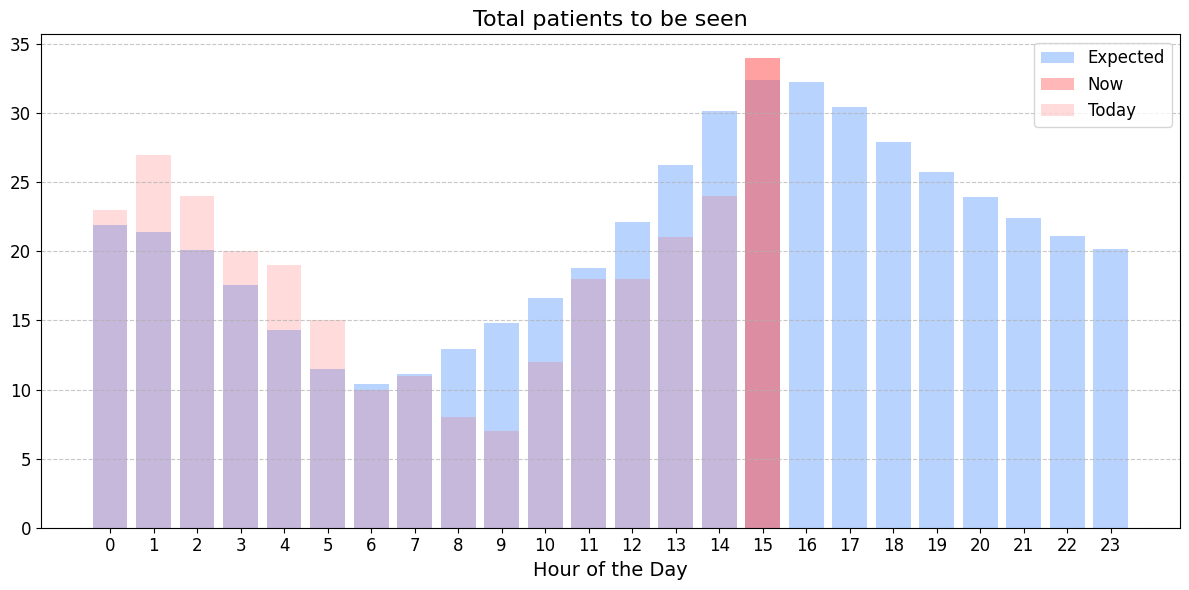

[{'metric': 'total_tbs', 'critical': False, 'time': Timestamp('2024-12-12 15:00:00'), 'value': np.float64(34.0), 'forecast': np.float64(49.65658086057017), 'forecast_time': Timestamp('2024-12-12 15:00:00'), 'forecast_value': np.float64(32.36954485851683), 'forecast_lower': np.float64(17.51430925197591), 'forecast_upper': np.float64(49.65658086057017)}]


,metric,critical,time,value,forecast,forecast_time,forecast_value,forecast_lower,forecast_upper
0,total_tbs,False,2024-12-12 15:00:00,34.0,49.656581,2024-12-12 15:00:00,32.369545,17.514309,49.656581


In [9]:
alerts = []

metric = 'total_tbs'

data = df.copy()

# Calculate total patients to be seen as the sum of specified columns

# Extract hour from the timestamp for grouping
data['Hour'] = pd.to_datetime(data['ds']).dt.hour

# Group by hour and calculate the average number of patients for each hour
hourly_data = data.groupby('Hour')[metric].mean()

# Identify the most recent timestamp's hour and its corresponding value
most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
most_recent_hour = most_recent_timestamp.hour
most_recent_value = data.loc[pd.to_datetime(data['ds']) == most_recent_timestamp, metric].iloc[0]
recent_data = data.loc[pd.to_datetime(data['ds']) >= pd.to_datetime(most_recent_timestamp.date()), metric]
recent_data = recent_data.reset_index(drop=True)

# Extract the day of the week for the most recent timestamp
most_recent_day_of_week = most_recent_timestamp.dayofweek

# Filter the data to include only rows matching the same day of the week
same_day_data = data[pd.to_datetime(data['ds']).dt.dayofweek == most_recent_day_of_week]

# Group by hour and calculate the average number of patients for this specific day of the week
hourly_data_same_day = same_day_data.groupby('Hour')[metric].mean()

prophet_data = output[['ds', metric+'_yhat', metric+'_yhat_lower', metric+'_yhat_upper']].copy()
prophet_data['Hour'] = pd.to_datetime(prophet_data['ds']).dt.hour
prophet_data_today = prophet_data[prophet_data.ds.dt.date == most_recent_timestamp.date()]
prophet_data_today = prophet_data_today.reset_index(drop=True)

if most_recent_value > prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']:
    now_color = '#ff4d4d'
    print(metric,'critical')
    total_tbs_critical = True
    total_tbs_critical_time = most_recent_timestamp
    total_tbs_critical_value = most_recent_value
    total_tbs_critical_forecast = prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']
    total_tbs_critical_forecast_time = prophet_data_today.iloc[most_recent_hour]['ds']
    total_tbs_critical_forecast_value = prophet_data_today.iloc[most_recent_hour][metric+'_yhat']
    total_tbs_critical_forecast_lower = prophet_data_today.iloc[most_recent_hour][metric+'_yhat_lower']
    total_tbs_critical_forecast_upper = prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']
    alerts.append({
        'metric': metric,
        'critical': True,
        'time': most_recent_timestamp,
        'value': most_recent_value,
        'forecast': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper'],
        'forecast_time': prophet_data_today.iloc[most_recent_hour]['ds'],
        'forecast_value': prophet_data_today.iloc[most_recent_hour][metric+'_yhat'],
        'forecast_lower': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_lower'],
        'forecast_upper': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']
    })
else:
    now_color = '#ff4d4d'
    print(metric,'not critical')
    alerts.append({
        'metric': metric,
        'critical': False,
        'time': most_recent_timestamp,
        'value': most_recent_value,
        'forecast': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper'],
        'forecast_time': prophet_data_today.iloc[most_recent_hour]['ds'],
        'forecast_value': prophet_data_today.iloc[most_recent_hour][metric+'_yhat'],
        'forecast_lower': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_lower'],
        'forecast_upper': prophet_data_today.iloc[most_recent_hour][metric+'_yhat_upper']
    })
    

prophet_data_today.tail()
# Plot the updated graph with colors matching the example and no vertical grid lines
plt.figure(figsize=(12, 6))
# plt.bar(hourly_data_same_day.index, hourly_data_same_day, color='#5293ff', alpha=0.4, label='Expected')
plt.bar(prophet_data_today.index, prophet_data_today[metric+'_yhat'], color='#5293ff', alpha=0.4, label='Expected')

plt.bar(
    most_recent_hour, most_recent_value, color=now_color, alpha=0.4, label='Now'
)
plt.bar(
    recent_data.index, recent_data, color='#ff4d4d', alpha=0.2, label='Today'
)
plt.xlabel('Hour of the Day', fontsize=14)
# plt.ylabel(metric, fontsize=14)
if metric == 'total_tbs':
    plt.title('Total patients to be seen', fontsize=16)
elif metric == 'vert_tbs':
    plt.title('Vertical patients to be seen', fontsize=16)
elif metric == 'pod_tbs':
    plt.title('Pod patients to be seen', fontsize=16)
else:
    plt.title(metric, fontsize=16)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')  # Remove vertical grid lines
plt.tight_layout()
plt.show()
# plt.savefig(metric+'.png')

print(alerts)

alerts_df = pd.DataFrame(alerts)
alerts_df.to_csv('calculated_KPIs_alerts.csv', index=False) # save alerts to csv

alerts_df

